<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 MultiplicationScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/2.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


<AxesSubplot: >

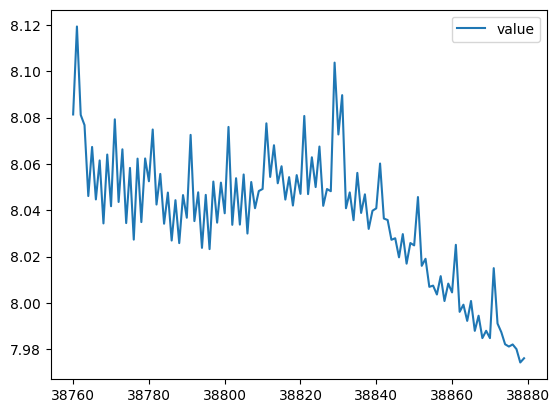

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_584879/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 89.31703991848262 %
smape 3.1552268268216443 %
smape 3.5207362275853837 %
smape 5.0582366423716785 %
smape 5.4962927839114215 %
smape 5.9469878099918665 %
smape 7.277617053597163 %
smape 7.538056479513711 %
smape 10.704507192580454 %
smape 14.43259985187521 %
smape 13.08512223467819 %
smape 12.09338463375165 %
smape 10.84126247535596 %
smape 11.161384943189177 %
smape 8.829359134566584 %
smape 10.8839788793706 %
smape 12.306372890574313 %
smape 10.0145593411507 %
smape 10.681956900959038 %
smape 9.127054300556798 %
smape 11.35074080902081 %
smape 9.270187100676045 %
smape 9.277478968302518 %
smape 8.32854575352275 %
smape 7.928508298882768 %
smape 8.889596549152772 %
smape 8.288750357895937 %
smape 8.45465349027348 %
smape 7.1413499661802975 %
smape 8.418997243756145 %
smape 8.461099790561704 %
smape 8.025606319999964 %
smape 8.66062912488171 %
smape 8.27573093928108 %
smape 8.483085708981324 %
smape 9.029088208080156 %
smape 7.980078124231523 %
smape 6.560471432844493 %
smape 6.

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.37138240251442767 %
SMAPE 0.2177757060676413 %
SMAPE 0.1952870009226899 %
SMAPE 0.141928843726987 %
SMAPE 0.08481773742641963 %
SMAPE 0.18816056537616532 %
SMAPE 0.3227799906351265 %
SMAPE 0.15829034173884793 %
SMAPE 0.12119519916996069 %
SMAPE 0.2935110199441624 %
SMAPE 0.2491019827175478 %
SMAPE 0.20313792182059842 %
SMAPE 0.1911339315956866 %
SMAPE 0.11213964908711205 %
SMAPE 0.11249392070749309 %
SMAPE 0.19500243919083005 %
SMAPE 0.14072253850861216 %
SMAPE 0.2640838828665437 %
SMAPE 0.22088087344491214 %
SMAPE 0.24463374551123707 %
SMAPE 0.18072450756494618 %
SMAPE 0.1691792169144719 %
SMAPE 0.23465548190142724 %
SMAPE 0.43045773220364936 %
SMAPE 0.24138700846015126 %
SMAPE 0.12945945913224932 %
SMAPE 0.2988927131082164 %
SMAPE 0.16298221217584796 %
SMAPE 0.10130878515792574 %
SMAPE 0.11415204468539743 %
SMAPE 0.13852067197512952 %
SMAPE 0.31223878043238074 %
SMAPE 0.14997042209506617 %
SMAPE 0.16269773853241531 %
SMAPE 0.10158723292533976 %
SMAPE 0.10354533383269882 %
SMA

SMAPE 0.07674942827753739 %
SMAPE 0.0824999752558142 %
SMAPE 0.12973754890117561 %
SMAPE 0.09991759650620224 %
SMAPE 0.12391361496565878 %
SMAPE 0.12388116604051902 %
SMAPE 0.1114202244543776 %
SMAPE 0.11156942200068443 %
SMAPE 0.10258866323715665 %
SMAPE 0.09033986688746154 %
SMAPE 0.07602869511327981 %
SMAPE 0.14331255659453745 %
SMAPE 0.07895219352303684 %
SMAPE 0.09454105308759608 %
SMAPE 0.07793686745662853 %
SMAPE 0.10812915113365307 %
SMAPE 0.1425432152045687 %
SMAPE 0.07885848257544126 %
SMAPE 0.08863055612891912 %
SMAPE 0.08415824968301422 %
SMAPE 0.09992801790713202 %
SMAPE 0.1031104206638247 %
SMAPE 0.10710778186148673 %
SMAPE 0.09262155844874087 %
SMAPE 0.10296953548731835 %
SMAPE 0.14051157561789296 %
SMAPE 0.053585199959343306 %
SMAPE 0.05225012857408729 %
SMAPE 0.10086459820286109 %
SMAPE 0.12907532691463075 %
SMAPE 0.10705267664138773 %
SMAPE 0.11734032299864339 %
SMAPE 0.2143275105900102 %
SMAPE 0.0938860941096209 %
SMAPE 0.11435583082129597 %
SMAPE 0.201307596287279 %

SMAPE 0.07552579148978111 %
SMAPE 0.08695968921529129 %
SMAPE 0.1121828448631277 %
SMAPE 0.16655538459417585 %
SMAPE 0.11925060176326951 %
SMAPE 0.1706418409885373 %
SMAPE 0.13311714688461507 %
SMAPE 0.14694983173103537 %
SMAPE 0.09348250371033373 %
SMAPE 0.06275258775713155 %
SMAPE 0.09854511275079858 %
SMAPE 0.10069918171757308 %
SMAPE 0.0993504824100455 %
SMAPE 0.21013219291580754 %
SMAPE 0.09724366520549665 %
SMAPE 0.06805112282472692 %
SMAPE 0.2388280880122693 %
SMAPE 0.09438452088579652 %
SMAPE 0.06854118815982702 %
SMAPE 0.22068814564954664 %
SMAPE 0.10411189107433927 %
SMAPE 0.10681210316261058 %
SMAPE 0.08726420629682252 %
SMAPE 0.20872753437834035 %
SMAPE 0.1004548419296043 %
SMAPE 0.15241640742169693 %
SMAPE 0.1043438923911708 %
SMAPE 0.145857445098045 %
SMAPE 0.13943337145610712 %
SMAPE 0.10848481703578727 %
SMAPE 0.04845645239447549 %
SMAPE 0.1563895112649334 %
SMAPE 0.04874578465671675 %
SMAPE 0.1387930339333252 %
SMAPE 0.14051938962074928 %
SMAPE 0.10076385423803914 %
SM

SMAPE 0.10020327504753368 %
SMAPE 0.1367621161466559 %
SMAPE 0.18521971961126837 %
SMAPE 0.0979468867317337 %
SMAPE 0.0812548470148613 %
SMAPE 0.09678719882867881 %
SMAPE 0.12803640927383952 %
SMAPE 0.10435167577361427 %
SMAPE 0.09741195150627391 %
SMAPE 0.12071273140918493 %
SMAPE 0.1343664997966698 %
SMAPE 0.10666466945076535 %
SMAPE 0.08290538959590776 %
SMAPE 0.06670915854783743 %
SMAPE 0.07870326313332043 %
SMAPE 0.08883239388524089 %
SMAPE 0.13157154274449567 %
SMAPE 0.07603443910466012 %
SMAPE 0.06989245151328305 %
SMAPE 0.10255224364627223 %
SMAPE 0.11709685023970451 %
SMAPE 0.1274075370997707 %
SMAPE 0.04509766210685484 %
SMAPE 0.0930335451796509 %
SMAPE 0.11910601496902017 %
SMAPE 0.1332335429615341 %
SMAPE 0.12128358709651366 %
SMAPE 0.10798313940077264 %
SMAPE 0.11342123730366893 %
SMAPE 0.15436391171897412 %
SMAPE 0.0700498287778828 %
SMAPE 0.0666761366337596 %
SMAPE 0.08210044822772034 %
SMAPE 0.12321583298125917 %
SMAPE 0.11269423248813837 %
SMAPE 0.08199598161445465 %
S

SMAPE 0.10116612508136315 %
SMAPE 0.17373311939991254 %
SMAPE 0.08015391631033708 %
SMAPE 0.06386302360238005 %
SMAPE 0.06303384512284538 %
SMAPE 0.14904232561093522 %
SMAPE 0.09301979107112857 %
SMAPE 0.08240618370473385 %
SMAPE 0.1059508521780117 %
SMAPE 0.1264606017502956 %
SMAPE 0.15759652565748183 %
SMAPE 0.10000465261600766 %
SMAPE 0.09158897953602718 %
SMAPE 0.10647153715854074 %
SMAPE 0.05905078661930929 %
SMAPE 0.10195052313474662 %
SMAPE 0.09041176425228059 %
SMAPE 0.09300557043422941 %
SMAPE 0.08390621666899278 %
SMAPE 0.0780820028448943 %
SMAPE 0.07273576312763907 %
SMAPE 0.061688950851930706 %
SMAPE 0.061024615753467515 %
SMAPE 0.06635079707484692 %
SMAPE 0.09849444896030946 %
SMAPE 0.12199695005256216 %
SMAPE 0.09846081914292881 %
SMAPE 0.044050033393432386 %
SMAPE 0.10753255798158533 %
SMAPE 0.11570024649358857 %
SMAPE 0.09976884281661569 %
SMAPE 0.09559409233770566 %
SMAPE 0.1848608690652327 %
SMAPE 0.0903144603707915 %
SMAPE 0.09915179093923145 %
SMAPE 0.08636450269625

SMAPE 0.0816895570824272 %
SMAPE 0.11219933531128846 %
SMAPE 0.10393171453870309 %
SMAPE 0.0871590448355164 %
SMAPE 0.1259772049888852 %
SMAPE 0.14852867175204665 %
SMAPE 0.060863343462187906 %
SMAPE 0.11372973599065972 %
SMAPE 0.10882177188250354 %
SMAPE 0.20797840016348346 %
SMAPE 0.11262958227780473 %
SMAPE 0.10241990597842233 %
SMAPE 0.09134109249771427 %
SMAPE 0.0810576277463042 %
SMAPE 0.07669496033486212 %
SMAPE 0.0631443161637435 %
SMAPE 0.06405957458309786 %
SMAPE 0.07377239488960186 %
SMAPE 0.0774685664800927 %
SMAPE 0.10044476806069724 %
SMAPE 0.07003253000561926 %
SMAPE 0.09170526832713222 %
SMAPE 0.12816952467983356 %
SMAPE 0.08323879913496057 %
SMAPE 0.15964056218035694 %
SMAPE 0.09100614768976811 %
SMAPE 0.11362389104579051 %
SMAPE 0.12468099036777858 %
SMAPE 0.12529437537887134 %
SMAPE 0.07548244172164686 %
SMAPE 0.08200939381003991 %
SMAPE 0.07114443289009387 %
SMAPE 0.08451840703128255 %
SMAPE 0.06450896565388575 %
SMAPE 0.08880066340316262 %
SMAPE 0.11864063825487393

SMAPE 0.18158363417023793 %
SMAPE 0.11425254171945197 %
SMAPE 0.0655377053524262 %
SMAPE 0.12180002777859045 %
SMAPE 0.10584331851532625 %
SMAPE 0.10906111200165468 %
SMAPE 0.11424766076288506 %
SMAPE 0.08994869955495233 %
SMAPE 0.04133778714458458 %
SMAPE 0.04170096039888449 %
SMAPE 0.1214822216097673 %
SMAPE 0.12207572869374417 %
SMAPE 0.07896168181014218 %
SMAPE 0.09875881843413481 %
SMAPE 0.06000391630880131 %
SMAPE 0.088313684987952 %
SMAPE 0.11807895913523225 %
SMAPE 0.06852744659590826 %
SMAPE 0.09548680723673897 %
SMAPE 0.08285660411638673 %
SMAPE 0.06188324997401651 %
SMAPE 0.06264097801613389 %
SMAPE 0.11318383445245674 %
SMAPE 0.18227772731916048 %
SMAPE 0.11453557522145275 %
SMAPE 0.11451943202155236 %
SMAPE 0.08678216890120893 %
SMAPE 0.06323720330146898 %
SMAPE 0.08673040662324638 %
SMAPE 0.0629505793503995 %
SMAPE 0.10055174897081542 %
SMAPE 0.09662900351617054 %
SMAPE 0.08600276688139274 %
SMAPE 0.1526456385763595 %
SMAPE 0.21640395234589963 %
SMAPE 0.08936402373001329 

SMAPE 0.11871040590585835 %
SMAPE 0.09859921229326574 %
SMAPE 0.06489876992282007 %
SMAPE 0.09041687592207381 %
SMAPE 0.09416971641621785 %
SMAPE 0.08052715774101671 %
SMAPE 0.12314758171487483 %
SMAPE 0.11401005231209639 %
SMAPE 0.11736468129674904 %
SMAPE 0.13915984826689964 %
SMAPE 0.12049387546358048 %
SMAPE 0.12082067993833334 %
SMAPE 0.16997271181139695 %
SMAPE 0.07895799221796551 %
SMAPE 0.12606986952414445 %
SMAPE 0.10417532031146949 %
SMAPE 0.13548322209680919 %
SMAPE 0.14129896479425952 %
SMAPE 0.1834070306213107 %
SMAPE 0.07880950523008323 %
SMAPE 0.14057197586862458 %
SMAPE 0.11736429138909443 %
SMAPE 0.1016376613038119 %
SMAPE 0.10854501966150565 %
SMAPE 0.14714959871344035 %
SMAPE 0.19565251321910182 %
SMAPE 0.21671803915165813 %
SMAPE 0.0774067929287412 %
SMAPE 0.18844341354997596 %
SMAPE 0.07715515300878906 %
SMAPE 0.14117486504346743 %
SMAPE 0.09214777491752102 %
SMAPE 0.1305850997014204 %
SMAPE 0.14154716571465542 %
SMAPE 0.06824545761446643 %
SMAPE 0.1046492262194078

SMAPE 0.09851303715458927 %
SMAPE 0.10537086692693266 %
SMAPE 0.05451178225030162 %
SMAPE 0.11065645625058095 %
SMAPE 0.11018348872312346 %
SMAPE 0.11049091918539489 %
SMAPE 0.08577435741290174 %
SMAPE 0.1105378873689915 %
SMAPE 0.11166893215704476 %
SMAPE 0.07921297206712552 %
SMAPE 0.21319191980001048 %
SMAPE 0.11568155951499648 %
SMAPE 0.09479104225692936 %
SMAPE 0.11770823716805978 %
SMAPE 0.06926940811320037 %
SMAPE 0.12860366205040918 %
SMAPE 0.06312967441385808 %
SMAPE 0.09226408106906092 %
SMAPE 0.11442474637897249 %
SMAPE 0.08314111662957657 %
SMAPE 0.13101713624382683 %
SMAPE 0.10971183373476379 %
SMAPE 0.17085849738032266 %
SMAPE 0.12376848896224145 %
SMAPE 0.11021722023724578 %
SMAPE 0.09505001829211324 %
SMAPE 0.09484293986031389 %
SMAPE 0.11032409315521363 %
SMAPE 0.07719723362151854 %
SMAPE 0.06707178265787661 %
SMAPE 0.10892010671523167 %
SMAPE 0.1099822407386455 %
SMAPE 0.10868353625482995 %
SMAPE 0.056208616950698335 %
SMAPE 0.16334557863592636 %
SMAPE 0.0806065286033

SMAPE 0.17565678076061886 %
SMAPE 0.2606198050452804 %
SMAPE 0.20379041427804626 %
SMAPE 0.09308189381897591 %
SMAPE 0.17724509194704297 %
SMAPE 0.38767674388509477 %
SMAPE 0.13844615979132868 %
SMAPE 0.17845947112664362 %
SMAPE 0.17684013266671172 %
SMAPE 0.18692991679017723 %
SMAPE 0.06196376591560693 %
SMAPE 0.15706560028405647 %
SMAPE 0.27232395922692376 %
SMAPE 0.3444321236529504 %
SMAPE 0.43245153677685266 %
SMAPE 0.5128508946363581 %
SMAPE 0.34825077762161527 %
SMAPE 0.14856911835704523 %
SMAPE 0.15581429793110146 %
SMAPE 0.27837679081130773 %
SMAPE 0.3591622824260412 %
SMAPE 0.28552378408858203 %
SMAPE 0.13651870320973103 %
SMAPE 0.0930404446112334 %
SMAPE 0.13545831364717742 %
SMAPE 0.1327933548918736 %
SMAPE 0.13734179095263244 %
SMAPE 0.18620265770732658 %
SMAPE 0.1109641046091383 %
SMAPE 0.16030259185936302 %
SMAPE 0.1123200505892399 %
SMAPE 0.19455526005185675 %
SMAPE 0.08294043715591215 %
SMAPE 0.07970977844706795 %
SMAPE 0.09563580468341115 %
SMAPE 0.16559863815018616 %


SMAPE 0.18525294457867858 %
SMAPE 0.3030885821135598 %
SMAPE 0.3434822299150255 %
SMAPE 0.09403852750710939 %
SMAPE 0.41272312489991236 %
SMAPE 0.2219984743533132 %
SMAPE 0.18066409065704647 %
SMAPE 0.11442353919483138 %
SMAPE 0.07187688436806638 %
SMAPE 0.32381172498571686 %
SMAPE 0.13834054802646278 %
SMAPE 0.11230847394472221 %
SMAPE 0.17314428724648678 %
SMAPE 0.2096130559075391 %
SMAPE 0.1722899256637902 %
SMAPE 0.11849649765827053 %
SMAPE 0.09277294752678245 %
SMAPE 0.14974506370981544 %
SMAPE 0.19001289832158363 %
SMAPE 0.3886004519808921 %
SMAPE 0.22774945312954742 %
SMAPE 0.08159667257859837 %
SMAPE 0.17740962077232325 %
SMAPE 0.12209119840372296 %
SMAPE 0.09143137276987545 %
SMAPE 0.07147560570297173 %
SMAPE 0.15974586837364768 %
SMAPE 0.07400213713737003 %
SMAPE 0.038940296217333525 %
SMAPE 0.17127131367305992 %
SMAPE 0.1277919022795686 %
SMAPE 0.08583706221543252 %
SMAPE 0.12823970765657577 %
SMAPE 0.19825182118074736 %
SMAPE 0.3233978853941153 %
SMAPE 0.240931798535712 %
S

SMAPE 0.32528534274024423 %
SMAPE 0.2560786747453676 %
SMAPE 0.055883772709421464 %
SMAPE 0.12666284597921162 %
SMAPE 0.18918504899556865 %
SMAPE 0.07825272920842963 %
SMAPE 0.22996579175378426 %
SMAPE 0.14007212284582238 %
SMAPE 0.2256641682018881 %
SMAPE 0.19911990673608673 %
SMAPE 0.10240178375988762 %
SMAPE 0.19781198061536998 %
SMAPE 0.08869078554926091 %
SMAPE 0.10878929400678318 %
SMAPE 0.08607345645350506 %
SMAPE 0.15606525351495293 %
SMAPE 0.22549254227033091 %
SMAPE 0.21502094021707308 %
SMAPE 0.16876481919825892 %
SMAPE 0.12156261149982583 %
SMAPE 0.12518968595804836 %
SMAPE 0.12522004910442774 %
SMAPE 0.15153062508488802 %
SMAPE 0.11461974336043566 %
SMAPE 0.15606170703790667 %
SMAPE 0.07332191584100656 %
SMAPE 0.17146448342464282 %
SMAPE 0.08940711274044588 %
SMAPE 0.10016108999553808 %
SMAPE 0.10867008559216629 %
SMAPE 0.113704886980031 %
SMAPE 0.2930230159799976 %
SMAPE 0.23711702368746046 %
SMAPE 0.27337683321457007 %
SMAPE 0.11858105863029778 %
SMAPE 0.1004118499504329

SMAPE 0.13054665143454258 %
SMAPE 0.18212370595040284 %
SMAPE 0.1494127149162523 %
SMAPE 0.08468852184159914 %
SMAPE 0.05822993125366338 %
SMAPE 0.03594797350888257 %
SMAPE 0.2470196988451789 %
SMAPE 0.19204272145361756 %
SMAPE 0.06171142516541295 %
SMAPE 0.06221644913603086 %
SMAPE 0.06810789964902142 %
SMAPE 0.20725157791184756 %
SMAPE 0.22228945108508924 %
SMAPE 0.23026899387150482 %
SMAPE 0.14656888131958112 %
SMAPE 0.12435511166768265 %
SMAPE 0.0733783577234135 %
SMAPE 0.10378426110401053 %
SMAPE 0.1307634947315819 %
SMAPE 0.10739813900909212 %
SMAPE 0.0774455688283524 %
SMAPE 0.12498532282643282 %
SMAPE 0.18833909393924841 %
SMAPE 0.19708540638839622 %
SMAPE 0.15919735555030456 %
SMAPE 0.10142085217739805 %
SMAPE 0.15591026237211736 %
SMAPE 0.10303789924228113 %
SMAPE 0.18293299651850248 %
SMAPE 0.09610511269784183 %
SMAPE 0.13108533225749852 %
SMAPE 0.06078835831704055 %
SMAPE 0.2060794427670771 %
SMAPE 0.12102080844852026 %
SMAPE 0.15178405814208418 %
SMAPE 0.08978810994085507 

SMAPE 0.1533645283743681 %
SMAPE 0.07134131199472904 %
SMAPE 0.1571290293286438 %
SMAPE 0.21730304283846635 %
SMAPE 0.051494610524969175 %
SMAPE 0.12784463190837414 %
SMAPE 0.1002558896507253 %
SMAPE 0.08527197857301871 %
SMAPE 0.13229892554045364 %
SMAPE 0.13430205978511367 %
SMAPE 0.08788531905520358 %
SMAPE 0.19133478274943627 %
SMAPE 0.1007066338554523 %
SMAPE 0.07132668848225876 %
SMAPE 0.031557626994299426 %
SMAPE 0.07367729551674529 %
SMAPE 0.08784171391528162 %
SMAPE 0.08833852753423344 %
SMAPE 0.07291749111118406 %
SMAPE 0.07695734143271693 %
SMAPE 0.07391903310690395 %
SMAPE 0.05056254619876199 %
SMAPE 0.19360980438614206 %
SMAPE 0.1648438591419108 %
SMAPE 0.1546836297493428 %
SMAPE 0.14099922922468977 %
SMAPE 0.10357556119492983 %
SMAPE 0.19631080473118345 %
SMAPE 0.11933244298234058 %
SMAPE 0.06039546670126583 %
SMAPE 0.09652690681650711 %
SMAPE 0.1999331403380893 %
SMAPE 0.049999376901553205 %
SMAPE 0.06798737287681433 %
SMAPE 0.1652884062054909 %
SMAPE 0.08019912083636882

SMAPE 0.04641255233218544 %
SMAPE 0.06522403351118555 %
SMAPE 0.03395180271945719 %
SMAPE 0.07148579667364174 %
SMAPE 0.05672861829953035 %
SMAPE 0.10030872017796355 %
SMAPE 0.1287973098310431 %
SMAPE 0.0798059155649753 %
SMAPE 0.06936206632235553 %
SMAPE 0.13788389584806282 %
SMAPE 0.0635813368514846 %
SMAPE 0.06627213014053268 %
SMAPE 0.03632899526928668 %
SMAPE 0.05813886187888784 %
SMAPE 0.07825038413466245 %
SMAPE 0.06931000502004281 %
SMAPE 0.043578888806223404 %
SMAPE 0.06545146362827836 %
SMAPE 0.05860742737263536 %
SMAPE 0.11522003053823937 %
SMAPE 0.06800099073961974 %
SMAPE 0.05727149703307077 %
SMAPE 0.05723732726619346 %
SMAPE 0.06451837084114231 %
SMAPE 0.0926227889576694 %
SMAPE 0.0917219788825605 %
SMAPE 0.0798623772038809 %
SMAPE 0.0721522358129505 %
SMAPE 0.13962338060809998 %
SMAPE 0.07192840923289623 %
SMAPE 0.0834659366885262 %
SMAPE 0.04751606125273611 %
SMAPE 0.05163187206395037 %
SMAPE 0.052947499316360336 %
SMAPE 0.0480283608666241 %
SMAPE 0.13668433763086796 %

SMAPE 0.09649771264366791 %
SMAPE 0.06671370290405321 %
SMAPE 0.062341915331671764 %
SMAPE 0.0702115066924307 %
SMAPE 0.0890679700992223 %
SMAPE 0.09395742096239701 %
SMAPE 0.09307089433059446 %
SMAPE 0.068797932727648 %
SMAPE 0.054257945419522 %
SMAPE 0.050173626189007337 %
SMAPE 0.0738589581259248 %
SMAPE 0.05822293866367545 %
SMAPE 0.06511943192072067 %
SMAPE 0.07429793967736487 %
SMAPE 0.05865574938070494 %
SMAPE 0.1011884358995303 %
SMAPE 0.08450005881604739 %
SMAPE 0.051666981875314384 %
SMAPE 0.04737338642371469 %
SMAPE 0.05864647901034914 %
SMAPE 0.11478605596585113 %
SMAPE 0.030752428607229376 %
SMAPE 0.05752551340037826 %
SMAPE 0.058477093967667315 %
SMAPE 0.09194642529337216 %
SMAPE 0.12788635633478407 %
SMAPE 0.08644012443073734 %
SMAPE 0.09517253519970836 %
SMAPE 0.08807178278175343 %
SMAPE 0.08104766439100786 %
SMAPE 0.06354537890001666 %
SMAPE 0.04984789431000536 %
SMAPE 0.08218394243704097 %
SMAPE 0.047085324717045296 %
SMAPE 0.07479853586528407 %
SMAPE 0.09895845194091

SMAPE 0.06002773032378172 %
SMAPE 0.15313369356590556 %
SMAPE 0.06530331676344758 %
SMAPE 0.07879231432968936 %
SMAPE 0.05170153110566389 %
SMAPE 0.14179460651939735 %
SMAPE 0.09537881810683757 %
SMAPE 0.10469147503863495 %
SMAPE 0.0333325053252338 %
SMAPE 0.09987967092729379 %
SMAPE 0.09551207075128332 %
SMAPE 0.11315059323533205 %
SMAPE 0.08489893708019736 %
SMAPE 0.08258373421085707 %
SMAPE 0.06232728875011162 %
SMAPE 0.0792162097459368 %
SMAPE 0.06867069811232795 %
SMAPE 0.06650531459513331 %
SMAPE 0.0721409132156623 %
SMAPE 0.0640257882878359 %
SMAPE 0.06101974117478904 %
SMAPE 0.07410855507373526 %
SMAPE 0.19946936546602956 %
SMAPE 0.1430705323582515 %
SMAPE 0.032689241714592754 %
SMAPE 0.0803383779896194 %
SMAPE 0.06909800344328687 %
SMAPE 0.05583465580730262 %
SMAPE 0.06702713875711197 %
SMAPE 0.061834973462282505 %
SMAPE 0.140016351477243 %
SMAPE 0.10607494134546869 %
SMAPE 0.09399111018228723 %
SMAPE 0.08818207244627274 %
SMAPE 0.04646918653725152 %
SMAPE 0.10941777127482055 

SMAPE 0.09345718077383935 %
SMAPE 0.0621719193068202 %
SMAPE 0.13804008770966902 %
SMAPE 0.1152598735061474 %
SMAPE 0.07522871688502164 %
SMAPE 0.09161469608625339 %
SMAPE 0.03131928579387022 %
SMAPE 0.055680768429738244 %
SMAPE 0.04830923181725666 %
SMAPE 0.06531660860400734 %
SMAPE 0.13784991692955373 %
SMAPE 0.06171478464830216 %
SMAPE 0.0677659948710243 %
SMAPE 0.031295419452362694 %
SMAPE 0.043152774497741575 %
SMAPE 0.09249114783597179 %
SMAPE 0.07866446670959704 %
SMAPE 0.031089745787994616 %
SMAPE 0.1391105175280245 %
SMAPE 0.09259053897403646 %
SMAPE 0.1393802736292855 %
SMAPE 0.0683241939045729 %
SMAPE 0.07531198385339621 %
SMAPE 0.05739874138271262 %
SMAPE 0.08733572621190433 %
SMAPE 0.06838995154612348 %
SMAPE 0.11014969991583713 %
SMAPE 0.09914210044894389 %
SMAPE 0.08238760805215861 %
SMAPE 0.0930645655898843 %
SMAPE 0.07045519762868935 %
SMAPE 0.09470892665990505 %
SMAPE 0.06584356779694645 %
SMAPE 0.19290723233461904 %
SMAPE 0.10544341448940033 %
SMAPE 0.086524734037936

SMAPE 0.09043073772136268 %
SMAPE 0.04905527492883266 %
SMAPE 0.07430712965560815 %
SMAPE 0.09180370520334691 %
SMAPE 0.07272553766460987 %
SMAPE 0.13741161035432015 %
SMAPE 0.06520525162432023 %
SMAPE 0.09549822175722511 %
SMAPE 0.08457426693439629 %
SMAPE 0.13703248029923998 %
SMAPE 0.05945833023110936 %
SMAPE 0.05656876999591986 %
SMAPE 0.08926943538472187 %
SMAPE 0.06497608930294518 %
SMAPE 0.04391824332952865 %
SMAPE 0.15336640843452187 %
SMAPE 0.09935399827418223 %
SMAPE 0.11114183421364032 %
SMAPE 0.1921744091087021 %
SMAPE 0.10394406810519286 %
SMAPE 0.05962213769134905 %
SMAPE 0.07520773356270638 %
SMAPE 0.06939802852866706 %
SMAPE 0.031408156435190904 %
SMAPE 0.07669568649635039 %
SMAPE 0.08403968163651143 %
SMAPE 0.06568379145755898 %
SMAPE 0.07757573286926345 %
SMAPE 0.06567960304573717 %
SMAPE 0.09174400848269215 %
SMAPE 0.062229519901336516 %
SMAPE 0.0663111470412332 %
SMAPE 0.0847835204558578 %
SMAPE 0.04081888665257338 %
SMAPE 0.03089479627669789 %
SMAPE 0.0665985214072

SMAPE 0.10669103275085946 %
SMAPE 0.1034164392394814 %
SMAPE 0.07210115612178924 %
SMAPE 0.10021600029722323 %
SMAPE 0.09372594975866377 %
SMAPE 0.09594028141327726 %
SMAPE 0.09188863543386105 %
SMAPE 0.11133202311430068 %
SMAPE 0.09374866628058953 %
SMAPE 0.09104082251724321 %
SMAPE 0.09133360628038645 %
SMAPE 0.10352869511552855 %
SMAPE 0.03358892856749662 %
SMAPE 0.05589761974738394 %
SMAPE 0.0924100827469374 %
SMAPE 0.052648581628773165 %
SMAPE 0.06685934902316149 %
SMAPE 0.06490031834073307 %
SMAPE 0.04929744940977798 %
SMAPE 0.05653949177940376 %
SMAPE 0.0647067561840231 %
SMAPE 0.045500006813199434 %
SMAPE 0.06754831341595491 %
SMAPE 0.10272476962109066 %
SMAPE 0.04590080081834458 %
SMAPE 0.0458642109849734 %
SMAPE 0.10541204250580449 %
SMAPE 0.046580251158161445 %
SMAPE 0.18902887385047507 %
SMAPE 0.06644896181478543 %
SMAPE 0.06944989504359 %
SMAPE 0.0930047063739039 %
SMAPE 0.09285006957361475 %
SMAPE 0.0863434844859512 %
SMAPE 0.06762847142636019 %
SMAPE 0.16266578513068453 

SMAPE 0.12411001287364343 %
SMAPE 0.07043759135376604 %
SMAPE 0.0640578592942802 %
SMAPE 0.05190285502567349 %
SMAPE 0.07543236157880528 %
SMAPE 0.08975027063829089 %
SMAPE 0.07398124902579184 %
SMAPE 0.08080577612508932 %
SMAPE 0.19504686388245318 %
SMAPE 0.11391347499102268 %
SMAPE 0.09411512154474622 %
SMAPE 0.0861578928279414 %
SMAPE 0.03172742178412591 %
SMAPE 0.065330125744822 %
SMAPE 0.088799416269012 %
SMAPE 0.04721541410253849 %
SMAPE 0.045601002351759234 %
SMAPE 0.0819508844797383 %
SMAPE 0.03222577678388916 %
SMAPE 0.06245288911668467 %
SMAPE 0.059873478567851635 %
SMAPE 0.031552551801723894 %
SMAPE 0.06819278109541926 %
SMAPE 0.07071971945515543 %
SMAPE 0.062330468036179816 %
SMAPE 0.06225554782577092 %
SMAPE 0.06577588734762685 %
SMAPE 0.049766722489948734 %
SMAPE 0.06432880096201643 %
SMAPE 0.13859594543464482 %
SMAPE 0.07504586422146531 %
SMAPE 0.06913309410083457 %
SMAPE 0.1087309908480165 %
SMAPE 0.056693535636441084 %
SMAPE 0.04923015220720117 %
SMAPE 0.07077935638653

SMAPE 0.07413812605955172 %
SMAPE 0.046715530644803493 %
SMAPE 0.060970661155806745 %
SMAPE 0.10365572093974153 %
SMAPE 0.06196522601567267 %
SMAPE 0.09735679247387452 %
SMAPE 0.05717845505660079 %
SMAPE 0.05793363154225518 %
SMAPE 0.09300697229878097 %
SMAPE 0.06080786875827471 %
SMAPE 0.10658647757327344 %
SMAPE 0.07152522908700121 %
SMAPE 0.13721729232929647 %
SMAPE 0.07497992706521472 %
SMAPE 0.05071645537645963 %
SMAPE 0.07031285563516576 %
SMAPE 0.07549089265739894 %
SMAPE 0.1911587550130207 %
SMAPE 0.10767875818783068 %
SMAPE 0.07375437129394413 %
SMAPE 0.13879210664890707 %
SMAPE 0.05655210758050089 %
SMAPE 0.07890966841250702 %
SMAPE 0.05732523587357719 %
SMAPE 0.07165649398666574 %
SMAPE 0.06683476661055465 %
SMAPE 0.04993429147179995 %
SMAPE 0.07061577781678352 %
SMAPE 0.04898830331876525 %
SMAPE 0.04831918687636971 %
SMAPE 0.07363064797493735 %
SMAPE 0.057271608471637585 %
SMAPE 0.05403797002122701 %
SMAPE 0.06273301731107495 %
SMAPE 0.06601073681395064 %
SMAPE 0.0924702405

SMAPE 0.07996671727869398 %
SMAPE 0.12304192479700758 %
SMAPE 0.05843951092447242 %
SMAPE 0.058935828105205694 %
SMAPE 0.061030706865039974 %
SMAPE 0.07440232954559178 %
SMAPE 0.04690065413251432 %
SMAPE 0.18493156410113443 %
SMAPE 0.1857241304460331 %
SMAPE 0.07675843583774622 %
SMAPE 0.08249867358244956 %
SMAPE 0.06413141036364323 %
SMAPE 0.06362634040596049 %
SMAPE 0.07413259066242972 %
SMAPE 0.05799475881553917 %
SMAPE 0.07736336207517525 %
SMAPE 0.09721473063382291 %
SMAPE 0.06567156486775616 %
SMAPE 0.09208661838601984 %
SMAPE 0.11283571308990759 %
SMAPE 0.0529363855007432 %
SMAPE 0.08629321114699451 %
SMAPE 0.032529501231806535 %
SMAPE 0.06631013011792675 %
SMAPE 0.05347593896976832 %
SMAPE 0.09032457861576404 %
SMAPE 0.060332575279971934 %
SMAPE 0.09130326731246896 %
SMAPE 0.07129801067651442 %
SMAPE 0.06447408936401189 %
SMAPE 0.07249457540456206 %
SMAPE 0.09404204088605184 %
SMAPE 0.0676307030512362 %
SMAPE 0.08928747479512822 %
SMAPE 0.10775669651638964 %
SMAPE 0.09491997207

SMAPE 0.05672519432846457 %
SMAPE 0.07655189944853191 %
SMAPE 0.18887130268558394 %
SMAPE 0.08038921819752431 %
SMAPE 0.1035939400060215 %
SMAPE 0.0545676979519385 %
SMAPE 0.05662504133618995 %
SMAPE 0.04880631287608139 %
SMAPE 0.046754862880106884 %
SMAPE 0.030332725626976757 %
SMAPE 0.0706112921446902 %
SMAPE 0.04726440058948356 %
SMAPE 0.04945165792378248 %
SMAPE 0.047276240963583405 %
SMAPE 0.06834711032433916 %
SMAPE 0.055985687657084775 %
SMAPE 0.056179575200076215 %
SMAPE 0.11128908336323205 %
SMAPE 0.06587574638115257 %
SMAPE 0.13384835826582275 %
SMAPE 0.0953278954657435 %
SMAPE 0.047634504487177765 %
SMAPE 0.04009239518141783 %
SMAPE 0.13420960489020217 %
SMAPE 0.10741070065705571 %
SMAPE 0.06402623558780363 %
SMAPE 0.06802729268201801 %
SMAPE 0.13252181507596106 %
SMAPE 0.049176684360190855 %
SMAPE 0.134742283335072 %
SMAPE 0.04623576696224063 %
SMAPE 0.04937982279921016 %
SMAPE 0.09052047267368835 %
SMAPE 0.13379470748623135 %
SMAPE 0.04911798642069698 %
SMAPE 0.08532917014

SMAPE 0.03259357984450162 %
SMAPE 0.07763384077816227 %
SMAPE 0.18672493600752205 %
SMAPE 0.13665805555774568 %
SMAPE 0.07853400807571376 %
SMAPE 0.0974950345025718 %
SMAPE 0.07043603457714198 %
SMAPE 0.08801517451036034 %
SMAPE 0.09142112562403781 %
SMAPE 0.07640951345820213 %
SMAPE 0.045204410096289394 %
SMAPE 0.09113402171351481 %
SMAPE 0.1401397695299238 %
SMAPE 0.06074584923680959 %
SMAPE 0.08254894028505078 %
SMAPE 0.08227782511448822 %
SMAPE 0.12649581215646322 %
SMAPE 0.07652424129184965 %
SMAPE 0.22741475659950083 %
SMAPE 0.04985192445815301 %
SMAPE 0.09017759714333806 %
SMAPE 0.057303772670820756 %
SMAPE 0.09255937092200384 %
SMAPE 0.05639891706596246 %
SMAPE 0.06349369285726425 %
SMAPE 0.09792372578522189 %
SMAPE 0.07750061026035837 %
SMAPE 0.09022834968345705 %
SMAPE 0.04640554593788693 %
SMAPE 0.13545627229177626 %
SMAPE 0.068716256206244 %
SMAPE 0.08186744329759676 %
SMAPE 0.10057795045031526 %
SMAPE 0.09048729548339907 %
SMAPE 0.08584020923581193 %
SMAPE 0.07310790080373

SMAPE 0.09616121809722245 %
SMAPE 0.06045882421949499 %
SMAPE 0.04510100450460186 %
SMAPE 0.08992627967563749 %
SMAPE 0.06670361625856458 %
SMAPE 0.08267849368601787 %
SMAPE 0.04603076896778191 %
SMAPE 0.09252039338571194 %
SMAPE 0.07409877087775385 %
SMAPE 0.06577441787032967 %
SMAPE 0.1396762354358998 %
SMAPE 0.05040157126859412 %
SMAPE 0.10036080101963307 %
SMAPE 0.09642895260185469 %
SMAPE 0.06571328650807118 %
SMAPE 0.11369286737863149 %
SMAPE 0.0679334103842848 %
SMAPE 0.031233619441081825 %
SMAPE 0.06657222164153609 %
SMAPE 0.0930676766220131 %
SMAPE 0.07386236014008318 %
SMAPE 0.06994146405122592 %
SMAPE 0.06275696655603724 %
SMAPE 0.07679966285650153 %
SMAPE 0.07265518197164056 %
SMAPE 0.052412477218695123 %
SMAPE 0.10675852962367571 %
SMAPE 0.06941486770665506 %
SMAPE 0.09700847022632786 %
SMAPE 0.13684224405733403 %
SMAPE 0.05599364742747071 %
SMAPE 0.08498790401370115 %
SMAPE 0.07845886550796877 %
SMAPE 0.04460886087417748 %
SMAPE 0.09223852665672894 %
SMAPE 0.0924261013642

SMAPE 0.09344277448326466 %
SMAPE 0.06856241734431023 %
SMAPE 0.045317472126498615 %
SMAPE 0.07181807673441654 %
SMAPE 0.05656567095138599 %
SMAPE 0.05645357069442981 %
SMAPE 0.06169268525377447 %
SMAPE 0.07253907454787623 %
SMAPE 0.04529271609135321 %
SMAPE 0.0438133855786873 %
SMAPE 0.06644946672668084 %
SMAPE 0.09377709223917918 %
SMAPE 0.08192457947006915 %
SMAPE 0.0651984330961568 %
SMAPE 0.09279799114301568 %
SMAPE 0.053763274862149046 %
SMAPE 0.09248398622730747 %
SMAPE 0.07473659966785817 %
SMAPE 0.031232983306836107 %
SMAPE 0.08909818032407202 %
SMAPE 0.0914091855611332 %
SMAPE 0.073683944973709 %
SMAPE 0.09115676752816171 %
SMAPE 0.037248844806526904 %
SMAPE 0.030860973667586222 %
SMAPE 0.06268908050697064 %
SMAPE 0.10517990463995373 %
SMAPE 0.06508896004424969 %
SMAPE 0.07801776664223325 %
SMAPE 0.06785601196452262 %
SMAPE 0.07110435906724888 %
SMAPE 0.10909964838174346 %
SMAPE 0.06817761546335532 %
SMAPE 0.051034072184847894 %
SMAPE 0.06726836387269941 %
SMAPE 0.06226551155

SMAPE 0.0300517815189778 %
SMAPE 0.05682775300624598 %
SMAPE 0.05835677267987194 %
SMAPE 0.06976835217858479 %
SMAPE 0.07779728923242146 %
SMAPE 0.03448262574079308 %
SMAPE 0.03037977943313308 %
SMAPE 0.06473058569463319 %
SMAPE 0.06401787868526299 %
SMAPE 0.1849605214811163 %
SMAPE 0.047020996143317006 %
SMAPE 0.04831453221231641 %
SMAPE 0.07938626264785853 %
SMAPE 0.02997231359076125 %
SMAPE 0.10309601049220873 %
SMAPE 0.046904329592507565 %
SMAPE 0.09734816174022853 %
SMAPE 0.18403940902499016 %
SMAPE 0.08519736663220101 %
SMAPE 0.030330869692988927 %
SMAPE 0.06792404320367496 %
SMAPE 0.044203213933997176 %
SMAPE 0.04576035617475327 %
SMAPE 0.08212346883965438 %
SMAPE 0.0604777173803086 %
SMAPE 0.05562330040970665 %
SMAPE 0.06774072067491943 %
SMAPE 0.090739935360034 %
SMAPE 0.08148094514581317 %
SMAPE 0.1331085400597658 %
SMAPE 0.1056090903337008 %
SMAPE 0.04976566363620805 %
SMAPE 0.10031193280156003 %
SMAPE 0.06341110480934731 %
SMAPE 0.045701278694878056 %
SMAPE 0.06304688099862

SMAPE 0.03013254417737699 %
SMAPE 0.030101594532190745 %
SMAPE 0.06495847591259007 %
SMAPE 0.05202466942000683 %
SMAPE 0.07012157357894466 %
SMAPE 0.06112771314474231 %
SMAPE 0.06027653741512041 %
SMAPE 0.06816261281579727 %
SMAPE 0.07172565511567086 %
SMAPE 0.0491697975269858 %
SMAPE 0.0440451491271574 %
SMAPE 0.1286097581323702 %
SMAPE 0.047166400291644095 %
SMAPE 0.057958500128734165 %
SMAPE 0.06432802994277154 %
SMAPE 0.1842152774479473 %
SMAPE 0.07729304291524386 %
SMAPE 0.029963249078718945 %
SMAPE 0.07057162131872019 %
SMAPE 0.07583300488295208 %
SMAPE 0.09032970004773233 %
SMAPE 0.09802832695277174 %
SMAPE 0.04474608697387339 %
SMAPE 0.044277299091845634 %
SMAPE 0.056137627874591096 %
SMAPE 0.04576681430796725 %
SMAPE 0.05956318378503056 %
SMAPE 0.07658890422590048 %
SMAPE 0.04544023679063969 %
SMAPE 0.04500239709386733 %
SMAPE 0.056845565219191485 %
SMAPE 0.0442869176822569 %
SMAPE 0.06615974498981814 %
SMAPE 0.06314829581720005 %
SMAPE 0.055238862201804295 %
SMAPE 0.056729470

SMAPE 0.06471561206160459 %
SMAPE 0.099632783443667 %
SMAPE 0.10857856566008195 %
SMAPE 0.13651236168516334 %
SMAPE 0.13400558571447618 %
SMAPE 0.09078979981859447 %
SMAPE 0.06012395370157719 %
SMAPE 0.07248225317016477 %
SMAPE 0.06069816621857171 %
SMAPE 0.08993402688065544 %
SMAPE 0.07054199016238272 %
SMAPE 0.09003671783102618 %
SMAPE 0.07311513352328802 %
SMAPE 0.0672643045991208 %
SMAPE 0.071556983952064 %
SMAPE 0.06114326437261752 %
SMAPE 0.08904889439145336 %
SMAPE 0.046371806081879186 %
SMAPE 0.05466377366087727 %
SMAPE 0.1336657518404536 %
SMAPE 0.07097862352475204 %
SMAPE 0.11839831992574545 %
SMAPE 0.055725368889397935 %
SMAPE 0.06990261631926842 %
SMAPE 0.07248831923061516 %
SMAPE 0.18563674803590402 %
SMAPE 0.04925142635784141 %
SMAPE 0.053438714360027 %
SMAPE 0.046687968836977234 %
SMAPE 0.06963647525117267 %
SMAPE 0.051255628437957064 %
SMAPE 0.037285186539634196 %
SMAPE 0.11775726478663275 %
SMAPE 0.122530286294932 %
SMAPE 0.21606213130326068 %
SMAPE 0.09043489616669831

SMAPE 0.06542045781299066 %
SMAPE 0.05846481755042987 %
SMAPE 0.0609912801965038 %
SMAPE 0.04889012309558893 %
SMAPE 0.08943861317118262 %
SMAPE 0.10808288721455028 %
SMAPE 0.04718931520392289 %
SMAPE 0.06441557469042891 %
SMAPE 0.09147732561859812 %
SMAPE 0.10378496394969261 %
SMAPE 0.05241451154142851 %
SMAPE 0.05465592998723423 %
SMAPE 0.07433598704483302 %
SMAPE 0.09143252558715176 %
SMAPE 0.05856744818720472 %
SMAPE 0.1091596313826102 %
SMAPE 0.07173018066168879 %
SMAPE 0.035537245308660204 %
SMAPE 0.056643176483476054 %
SMAPE 0.10861352480742426 %
SMAPE 0.08434116020998772 %
SMAPE 0.07173641668964592 %
SMAPE 0.04124784330588227 %
SMAPE 0.06582845607408672 %
SMAPE 0.07264443987514824 %
SMAPE 0.0879350523928224 %
SMAPE 0.04191821644440097 %
SMAPE 0.06937106246823532 %
SMAPE 0.0920279577258043 %
SMAPE 0.04872499233965755 %
SMAPE 0.06996267500289832 %
SMAPE 0.07899456483210088 %
SMAPE 0.09412936252010695 %
SMAPE 0.06436898646040845 %
SMAPE 0.08626204916981806 %
SMAPE 0.06474286523803

SMAPE 0.06649113383400618 %
SMAPE 0.04198424618266472 %
SMAPE 0.08030897837488737 %
SMAPE 0.061060252751310884 %
SMAPE 0.03009701142309495 %
SMAPE 0.0519107497236746 %
SMAPE 0.06108037700687419 %
SMAPE 0.061693492360063835 %
SMAPE 0.03877676321462786 %
SMAPE 0.06296870460766968 %
SMAPE 0.04526131064631045 %
SMAPE 0.06697399903350743 %
SMAPE 0.09125162296550116 %
SMAPE 0.06397111814794698 %
SMAPE 0.09319430820141861 %
SMAPE 0.07010041134253697 %
SMAPE 0.033485362240298855 %
SMAPE 0.047082666001188045 %
SMAPE 0.09668333187437383 %
SMAPE 0.09082578716333956 %
SMAPE 0.07599185336221126 %
SMAPE 0.06506740285749402 %
SMAPE 0.09103882533236174 %
SMAPE 0.09085849714756478 %
SMAPE 0.03010700075464001 %
SMAPE 0.06784618958954525 %
SMAPE 0.04866568151919637 %
SMAPE 0.03019819253574951 %
SMAPE 0.05790614910131353 %
SMAPE 0.058553959497430697 %
SMAPE 0.06097799000235682 %
SMAPE 0.07272423059157518 %
SMAPE 0.04357646973221563 %
SMAPE 0.047781950732314726 %
SMAPE 0.04357570861066051 %
SMAPE 0.0434896

SMAPE 0.09899941294861492 %
SMAPE 0.11707011429462 %
SMAPE 0.0882553538283446 %
SMAPE 0.06590476525207123 %
SMAPE 0.0684059295881525 %
SMAPE 0.08982371074444018 %
SMAPE 0.07286001452484925 %
SMAPE 0.08584547347709304 %
SMAPE 0.1008796911482932 %
SMAPE 0.09292878078849753 %
SMAPE 0.0803518024913501 %
SMAPE 0.19811200618642033 %
SMAPE 0.16398716605817754 %
SMAPE 0.09518000134266913 %
SMAPE 0.10382829305126506 %
SMAPE 0.09558976623156923 %
SMAPE 0.14857368983211927 %
SMAPE 0.0861742394099565 %
SMAPE 0.19643053591789794 %
SMAPE 0.1658118705090601 %
SMAPE 0.13124672792764613 %
SMAPE 0.13135896298263106 %
SMAPE 0.12152658730519761 %
SMAPE 0.12907023342177126 %
SMAPE 0.080394119450375 %
SMAPE 0.0912659499903441 %
SMAPE 0.06088040845133946 %
SMAPE 0.07975756956966507 %
SMAPE 0.03741415577223961 %
SMAPE 0.08024278169057197 %
SMAPE 0.07761979456336121 %
SMAPE 0.09594810165708623 %
SMAPE 0.07590900686432178 %
SMAPE 0.14793400444068538 %
SMAPE 0.07729453381034546 %
SMAPE 0.15523901797496364 %
SMAP

SMAPE 0.07300900025836654 %
SMAPE 0.04632219470272503 %
SMAPE 0.06265297069603548 %
SMAPE 0.13117922187848308 %
SMAPE 0.07654055493003398 %
SMAPE 0.07729374410155287 %
SMAPE 0.04318835849335301 %
SMAPE 0.10708211743622087 %
SMAPE 0.0426953643069794 %
SMAPE 0.05654881772125009 %
SMAPE 0.08850027486596446 %
SMAPE 0.10675568488022691 %
SMAPE 0.13015923292732623 %
SMAPE 0.12375596436686465 %
SMAPE 0.14823693853327313 %
SMAPE 0.1206126762799613 %
SMAPE 0.07963924603109263 %
SMAPE 0.1469581659166579 %
SMAPE 0.11398016114799248 %
SMAPE 0.10579419192072237 %
SMAPE 0.1173814383437275 %
SMAPE 0.17161439795927436 %
SMAPE 0.07965094431347097 %
SMAPE 0.07595265227587333 %
SMAPE 0.11448877167276805 %
SMAPE 0.09032847687922185 %
SMAPE 0.08559935030825727 %
SMAPE 0.05590968196338508 %
SMAPE 0.08266482135968545 %
SMAPE 0.09161270350159612 %
SMAPE 0.24211199065575784 %
SMAPE 0.08938096291308284 %
SMAPE 0.07644843850835059 %
SMAPE 0.09720602084780694 %
SMAPE 0.051661206379776566 %
SMAPE 0.102121390524644

SMAPE 0.0902294073603116 %
SMAPE 0.09616792359094006 %
SMAPE 0.06676225277192316 %
SMAPE 0.0856218063780716 %
SMAPE 0.03039046308822435 %
SMAPE 0.10740772858844139 %
SMAPE 0.0659349921137391 %
SMAPE 0.1161551667155436 %
SMAPE 0.09964597224006867 %
SMAPE 0.087399487325456 %
SMAPE 0.05573343293326616 %
SMAPE 0.06797004545705931 %
SMAPE 0.07244091473054937 %
SMAPE 0.07443527998839272 %
SMAPE 0.09390309356269455 %
SMAPE 0.09972686999640246 %
SMAPE 0.06930013712690197 %
SMAPE 0.07651869775577325 %
SMAPE 0.06533000830768287 %
SMAPE 0.07030422875686781 %
SMAPE 0.07297411527770237 %
SMAPE 0.08311983000839973 %
SMAPE 0.11837341160480719 %
SMAPE 0.0833173882929259 %
SMAPE 0.07803149658980146 %
SMAPE 0.09142935781153483 %
SMAPE 0.10309290346685884 %
SMAPE 0.04739925210697038 %
SMAPE 0.0888412547428743 %
SMAPE 0.08782491997772013 %
SMAPE 0.08802249045356803 %
SMAPE 0.13954912856570445 %
SMAPE 0.07373335333522846 %
SMAPE 0.06209799189855403 %
SMAPE 0.09603463059738715 %
SMAPE 0.10843564162314578 %


In [17]:
len(pred_list)

10080

In [18]:
pred_list

[7.8751325607299805,
 7.885011196136475,
 7.977118015289307,
 7.916863441467285,
 7.88451623916626,
 7.833523273468018,
 7.978031635284424,
 7.972316741943359,
 8.018562316894531,
 8.008333206176758,
 8.030807495117188,
 8.060406684875488,
 7.964987754821777,
 7.862208366394043,
 7.845808506011963,
 7.857271671295166,
 7.834953308105469,
 7.81842041015625,
 7.887909412384033,
 7.85059118270874,
 7.892507076263428,
 8.0220947265625,
 8.053058624267578,
 7.932207107543945,
 7.914455890655518,
 7.950179576873779,
 7.921745300292969,
 7.887639045715332,
 7.908030986785889,
 7.8740715980529785,
 7.763421058654785,
 7.844661235809326,
 7.870578289031982,
 7.853785991668701,
 7.930069446563721,
 7.9438982009887695,
 7.806878566741943,
 7.809403896331787,
 7.85764217376709,
 7.946072101593018,
 7.939607620239258,
 7.923575401306152,
 7.990129470825195,
 7.962158203125,
 7.8416337966918945,
 7.863838195800781,
 7.787404537200928,
 7.769361972808838,
 7.768082618713379,
 7.779216289520264,
 7.77

In [19]:
target=list(target.values.reshape(-1))

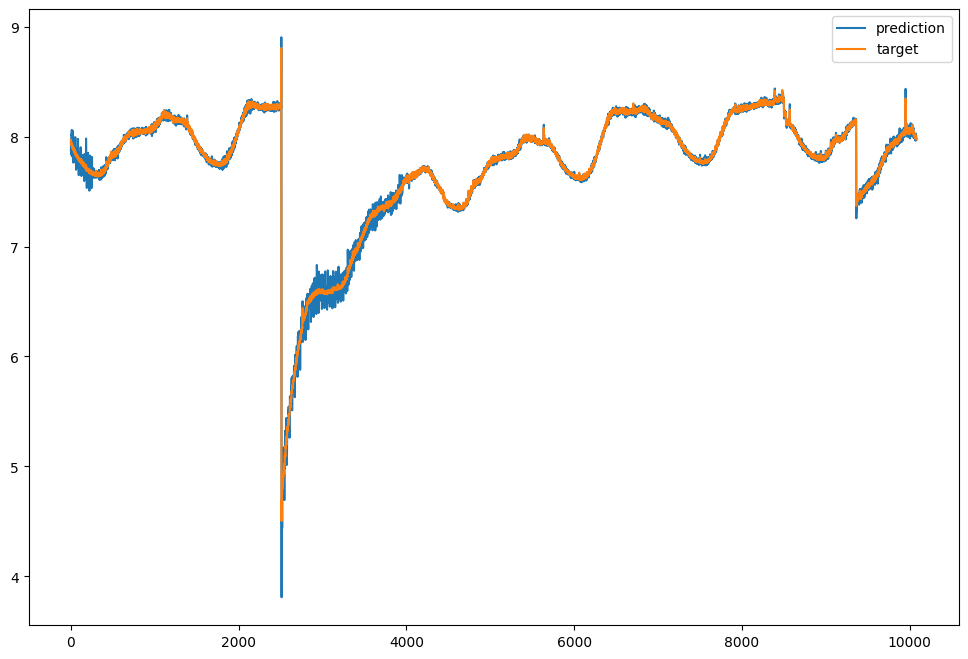

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([7.87513256, 7.8850112 , 7.97711802, ..., 7.99602222, 7.96631908,
       7.98174286])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[7.941656],
       [7.972712],
       [7.94328 ],
       ...,
       [7.980072],
       [7.974312],
       [7.976136]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 0.31667680013924837 %
RMSE 0.04349374398589134
MAPE 0.31695663928985596 %


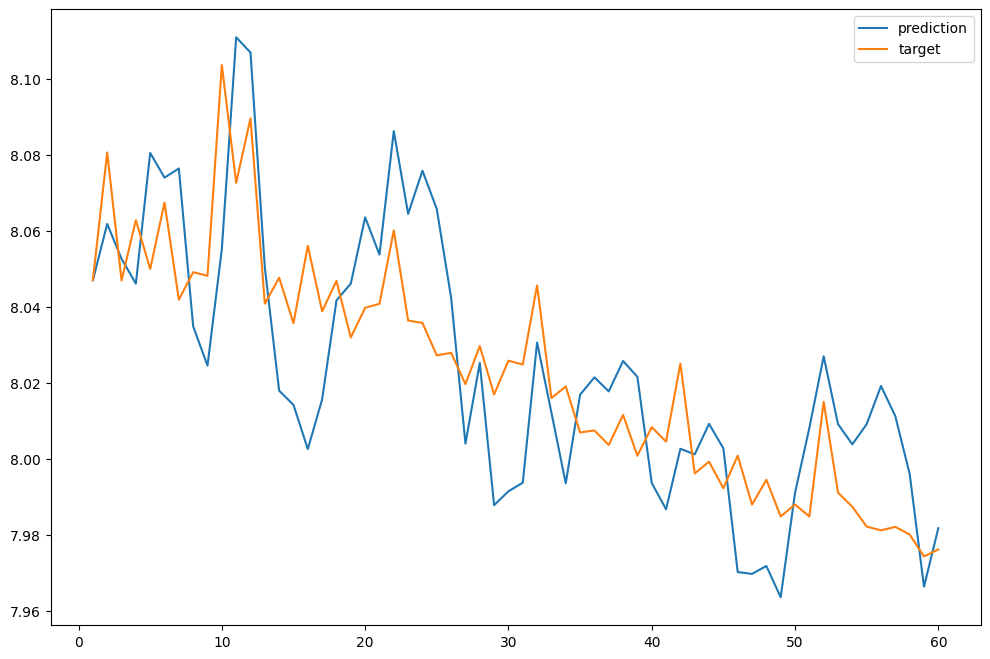

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.4089787459799222